# Author: Nicolas Hernandez

## Forecasting Sticker Sales

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")
train.dropna(inplace = True)
train['date'] = pd.to_datetime(train['date'])
train.head()

,id,date,country,store,product,num_sold
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0


Let's check for stationarity

In [3]:
from statsmodels.tsa.stattools import adfuller

In [4]:
train = train.set_index('date')
result = adfuller(train['num_sold'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')
if result[1] > 0.05:
    print("The data is non-stationary.")
else:
    print("The data is stationary.")

ADF Statistic: -32.10570496433412
p-value: 0.0
Critical Values:
1%: -3.430379566523776
5%: -2.8615530680191887
10%: -2.5667769556355844
The data is stationary.


More negative values of ADF indicate stronger evidence for stationarity. 

Data has a constant mean and variance over time, and no differencing is required for further time series modeling.

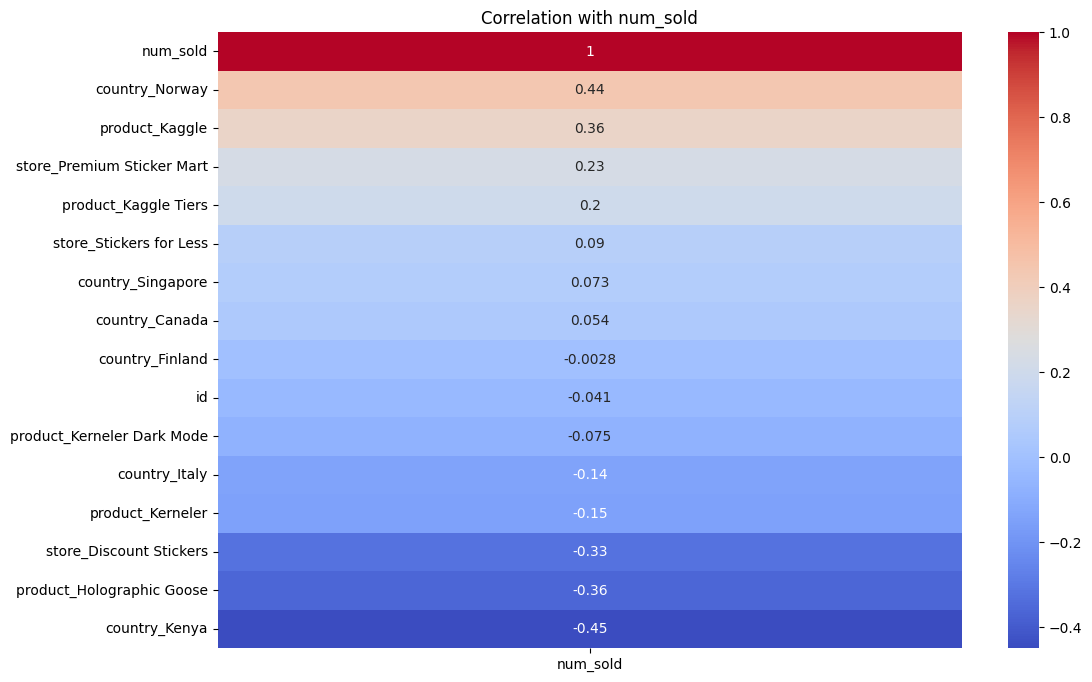

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# One-hot encode the categorical columns for correlation analysis
train_encoded = pd.get_dummies(train, columns=['country', 'store', 'product'])

# Calculate the correlation matrix
corr_matrix = train_encoded.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['num_sold']].sort_values(by='num_sold', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with num_sold')
plt.show()

Let's include holidays

In [6]:
import holidays

In [7]:
def is_holiday(row):
    try:
        country_holidays = holidays.country_holidays(row['country'])
        return 1 if row.name in country_holidays else 0
    except:
        return 0  # If the country is not supported

# Apply the holiday feature for each country
train['is_holiday'] = train.apply(is_holiday, axis=1)
train.head()

,id,country,store,product,num_sold,is_holiday
date,,,,,,
2010-01-01,1,Canada,Discount Stickers,Kaggle,973.0,1
2010-01-01,2,Canada,Discount Stickers,Kaggle Tiers,906.0,1
2010-01-01,3,Canada,Discount Stickers,Kerneler,423.0,1
2010-01-01,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1
2010-01-01,5,Canada,Stickers for Less,Holographic Goose,300.0,1


In [8]:
train['is_holiday'].value_counts()

is_holiday
0    214311
1      6948
Name: count, dtype: int64

A lag feature captures the value of a time series at a previous point in time. It helps model temporal dependencies where past values influence future behavior.

A rolling mean smooths the time series by averaging the values over a fixed window of time. It helps reduce noise and highlight trends.

In [9]:
train['sold_lag_1'] = train['num_sold'].shift(1)
train['sold_7d_avg'] = train['num_sold'].rolling(window=7).mean()
train = train.dropna()

## Model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
train_2015 = train[train.index < '2016-01-01']
train_2016 = train[train.index >= '2016-01-01']


X_train, y_train = train_2015.drop(columns=['num_sold']), train_2015['num_sold']
X_test, y_test = train_2016.drop(columns=['num_sold']), train_2016['num_sold']

In [12]:
train_2015.head()

,id,country,store,product,num_sold,is_holiday,sold_lag_1,sold_7d_avg
date,,,,,,,,
2010-01-01,7,Canada,Stickers for Less,Kaggle Tiers,1659.0,1,1837.0,941.285714
2010-01-01,8,Canada,Stickers for Less,Kerneler,807.0,1,1659.0,917.571429
2010-01-01,9,Canada,Stickers for Less,Kerneler Dark Mode,940.0,1,807.0,922.428571
2010-01-01,10,Canada,Premium Sticker Mart,Holographic Goose,375.0,1,940.0,915.571429
2010-01-01,11,Canada,Premium Sticker Mart,Kaggle,2212.0,1,375.0,1161.428571


### ARIMA

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order=(1, 0, 1)) 
arima_fit = model.fit()
print(arima_fit.summary())

y_pred = arima_fit.forecast(steps=len(train_2016))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               num_sold   No. Observations:               189486
Model:                 ARIMA(1, 0, 1)   Log Likelihood            -1488650.991
Date:                Wed, 15 Jan 2025   AIC                        2977309.983
Time:                        01:14:39   BIC                        2977350.591
Sample:                             0   HQIC                       2977321.963
                             - 189486                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        765.0922      4.804    159.268      0.000     755.677     774.507
ar.L1          0.7390      0.003    264.412      0.000       0.734       0.744
ma.L1         -0.3862      0.004   -101.923      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
from sklearn.metrics import mean_absolute_percentage_error

In [15]:
print(mean_absolute_percentage_error(y_test, y_pred))

8.815936049944817


### XGBoost

In [47]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import numpy as np

In [48]:
train.head()

,id,country,store,product,num_sold,is_holiday,sold_lag_1,sold_7d_avg,date,day_of_year,...,day_of_week,day_sin,day_cos,month_sin,month_cos,week_sin,week_cos,country_encoded,store_encoded,product_encoded
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,7,Canada,Stickers for Less,Kaggle Tiers,1659.0,1,1837.0,941.285714,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,2,2
2010-01-01,8,Canada,Stickers for Less,Kerneler,807.0,1,1659.0,917.571429,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,2,3
2010-01-01,9,Canada,Stickers for Less,Kerneler Dark Mode,940.0,1,807.0,922.428571,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,2,4
2010-01-01,10,Canada,Premium Sticker Mart,Holographic Goose,375.0,1,940.0,915.571429,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,1,0
2010-01-01,11,Canada,Premium Sticker Mart,Kaggle,2212.0,1,375.0,1161.428571,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,1,1


In [49]:
train['date'] = train.index

train['day_of_year'] = train['date'].dt.dayofyear
train['month'] = train['date'].dt.month
train['day_of_week'] = train['date'].dt.dayofweek

train['day_sin'] = np.sin(2 * np.pi * train['day_of_year'] / 365)
train['day_cos'] = np.cos(2 * np.pi * train['day_of_year'] / 365)

train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)

train['week_sin'] = np.sin(2 * np.pi * train['day_of_week'] / 7)
train['week_cos'] = np.cos(2 * np.pi * train['day_of_week'] / 7)

le_country = LabelEncoder()
le_store = LabelEncoder()
le_product = LabelEncoder()

train['country_encoded'] = le_country.fit_transform(train['country'])
train['store_encoded'] = le_store.fit_transform(train['store'])
train['product_encoded'] = le_product.fit_transform(train['product'])

train.head()

,id,country,store,product,num_sold,is_holiday,sold_lag_1,sold_7d_avg,date,day_of_year,...,day_of_week,day_sin,day_cos,month_sin,month_cos,week_sin,week_cos,country_encoded,store_encoded,product_encoded
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,7,Canada,Stickers for Less,Kaggle Tiers,1659.0,1,1837.0,941.285714,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,2,2
2010-01-01,8,Canada,Stickers for Less,Kerneler,807.0,1,1659.0,917.571429,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,2,3
2010-01-01,9,Canada,Stickers for Less,Kerneler Dark Mode,940.0,1,807.0,922.428571,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,2,4
2010-01-01,10,Canada,Premium Sticker Mart,Holographic Goose,375.0,1,940.0,915.571429,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,1,0
2010-01-01,11,Canada,Premium Sticker Mart,Kaggle,2212.0,1,375.0,1161.428571,2010-01-01,1,...,4,0.017213,0.999852,0.5,0.866025,-0.433884,-0.900969,0,1,1


In [50]:
X = train.drop(columns=['num_sold', 'country', 'store', 'product', 'id', 'date'])
y = train['num_sold']

In [51]:
train_size = int(len(train) * 0.8) 
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [52]:
xgb_model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

In [53]:
print(mean_absolute_percentage_error(y_test, y_pred))

0.1273759788210524


In [58]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

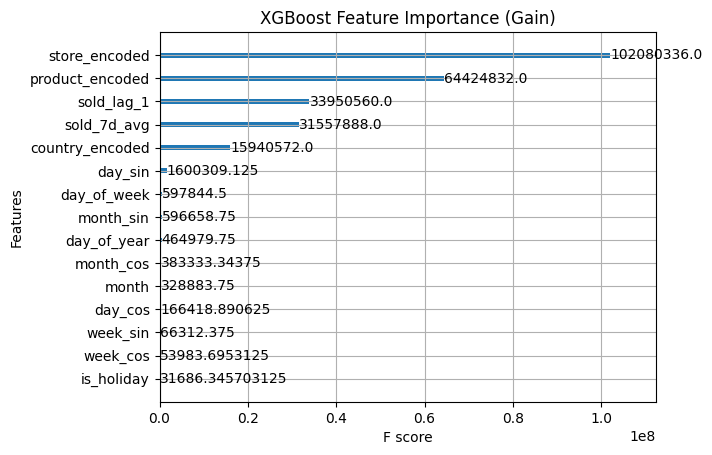

In [59]:
plot_importance(xgb_model, importance_type="gain")
plt.title('XGBoost Feature Importance (Gain)')
plt.show()

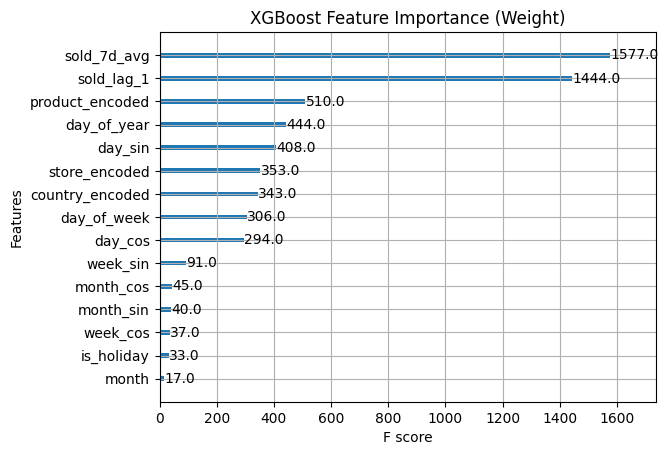

In [60]:
plot_importance(xgb_model, importance_type="weight")
plt.title('XGBoost Feature Importance (Weight)')
plt.show()

In [61]:
feature_importance = xgb_model.get_booster().get_score(importance_type="gain")

# Convert to a DataFrame for easier analysis
import pandas as pd
importance_df = pd.DataFrame(list(feature_importance.items()), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)
print(importance_df)

            Feature    Importance
13    store_encoded  1.020803e+08
14  product_encoded  6.442483e+07
1        sold_lag_1  3.395056e+07
2       sold_7d_avg  3.155789e+07
12  country_encoded  1.594057e+07
6           day_sin  1.600309e+06
5       day_of_week  5.978445e+05
8         month_sin  5.966588e+05
3       day_of_year  4.649798e+05
9         month_cos  3.833333e+05
4             month  3.288838e+05
7           day_cos  1.664189e+05
10         week_sin  6.631238e+04
11         week_cos  5.398370e+04
0        is_holiday  3.168635e+04


#### SHAP analysis

In [63]:
import shap

In [64]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

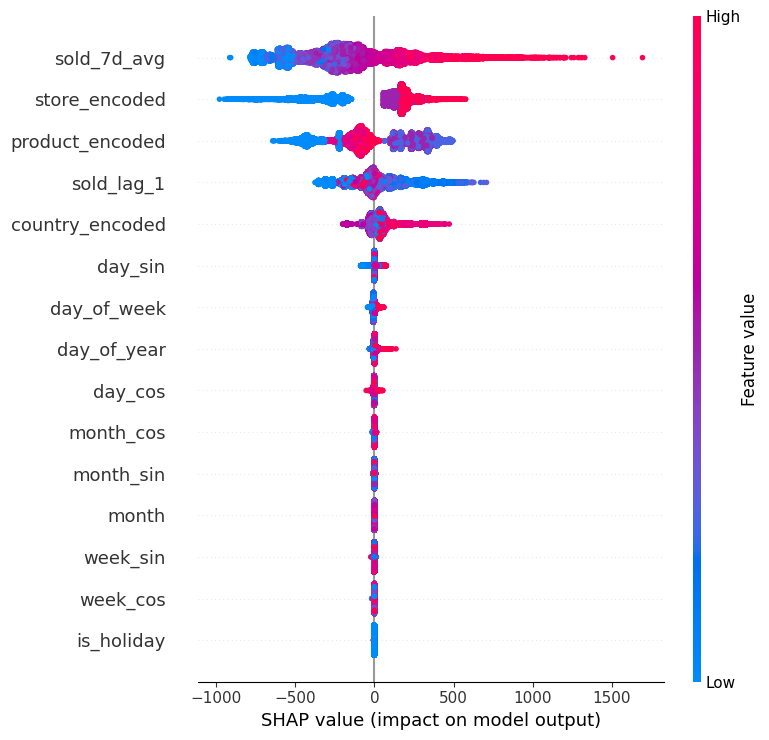

In [65]:
shap.summary_plot(shap_values, X_test)

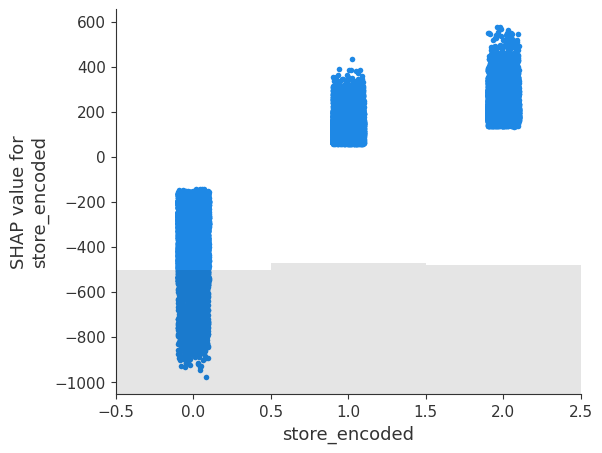

In [69]:
shap.plots.scatter(shap_values[:, "store_encoded"])

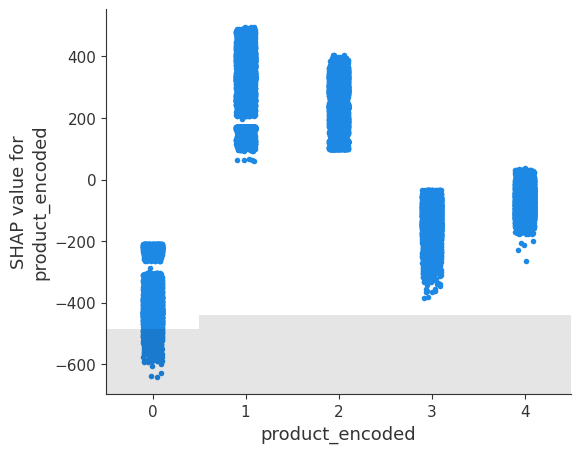

In [71]:
shap.plots.scatter(shap_values[:, "product_encoded"])

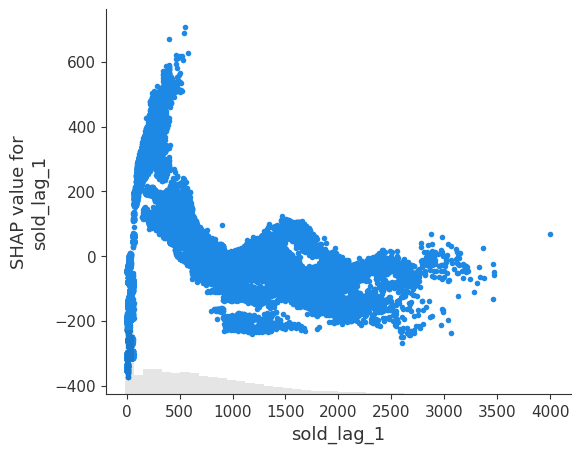

In [73]:
shap.plots.scatter(shap_values[:, "sold_lag_1"])

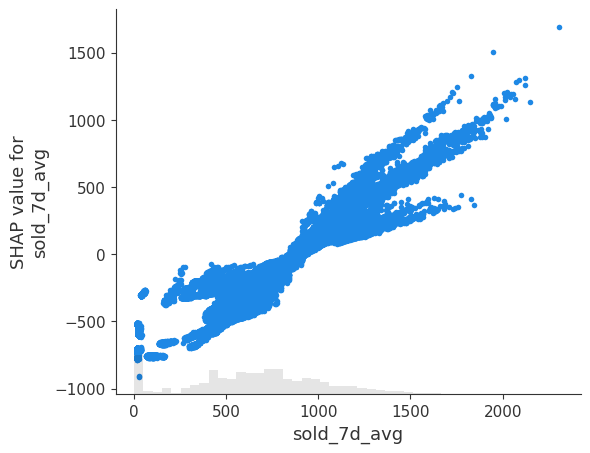

In [74]:
shap.plots.scatter(shap_values[:, "sold_7d_avg"])

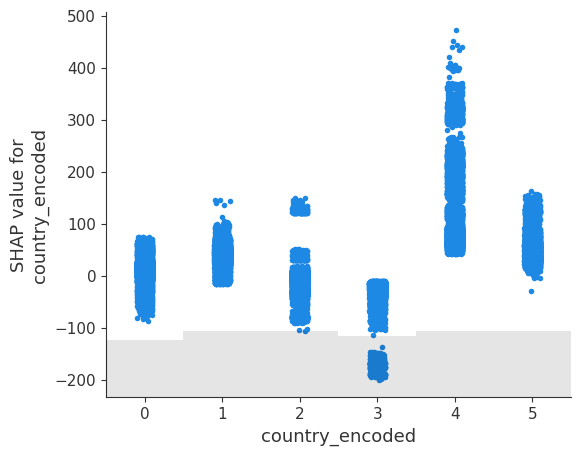

In [75]:
shap.plots.scatter(shap_values[:, "country_encoded"])

All the date variables are not really that important, so i would not take it into account. Holiday won´t we taken into account as the importance is really low.

Next notebook a model will be developed using the following variables:
* store_encoded
* product_encoded
* sold_lag_1
* sold_7d_avg
* country_encoded

A general model will be tested. If the results are not working a model for each country will be developed.

In [ ]:
Time: ~ 2-3 hours